In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

In [55]:
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import regularizers

### Blog : building autoencoders in keras
https://blog.keras.io/building-autoencoders-in-keras.html

In [68]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print x_train.shape
print x_test.shape

(60000, 784)
(10000, 784)


In [69]:
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))

if True: # no sparsity constraint
    encoded = Dense(encoding_dim, activation='relu')(input_img)
else:
    encoded = Dense(encoding_dim, activation='relu',
                    activity_regularizer=regularizers.activity_l1(10e-5))(input_img)

# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)

# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [70]:
# train autoencoder to reconstruct MNIST digits
# use a per-pixel binary crossentropy loss
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [71]:
autoencoder.fit(x_train, x_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s - loss: 0.3690 - val_loss: 0.2722
Epoch 2/50
60000/60000 [==============================] - 1s - loss: 0.2640 - val_loss: 0.2523
Epoch 3/50
60000/60000 [==============================] - 1s - loss: 0.2420 - val_loss: 0.2296
Epoch 4/50
60000/60000 [==============================] - 1s - loss: 0.2222 - val_loss: 0.2128
Epoch 5/50
60000/60000 [==============================] - 1s - loss: 0.2080 - val_loss: 0.2009
Epoch 6/50
60000/60000 [==============================] - 1s - loss: 0.1977 - val_loss: 0.1920
Epoch 7/50
60000/60000 [==============================] - 1s - loss: 0.1899 - val_loss: 0.1850
Epoch 8/50
60000/60000 [==============================] - 1s - loss: 0.1832 - val_loss: 0.1786
Epoch 9/50
60000/60000 [==============================] - 1s - loss: 0.1772 - val_loss: 0.1729
Epoch 10/50
60000/60000 [==============================] - 1s - loss: 0.1717 - val_loss: 0.1679

In [72]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

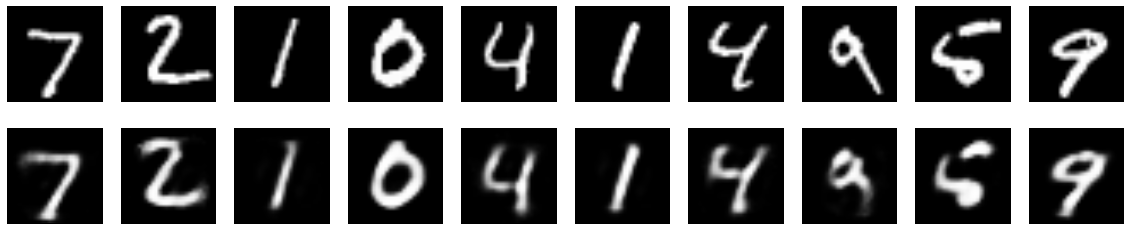

In [73]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Adding noise to input data

In [77]:
#(x_train, _), (x_test, _) = mnist.load_data()

#x_train = x_train.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.
#x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
#x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

noise_factor = 0.25
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [78]:
encoded_noisy_imgs = encoder.predict(x_test_noisy)
decoded_noisy_imgs = decoder.predict(encoded_noisy_imgs)

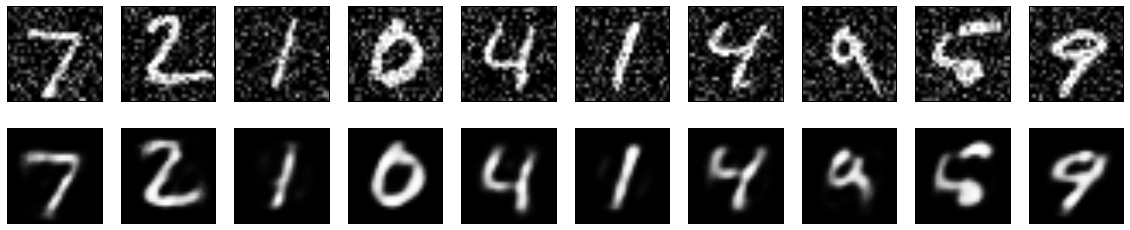

In [79]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_noisy_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Convolutional Auto-Encoder

In [80]:
# WARNING : NOT SAME SHAPE AS BEFORE
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 1, 28, 28))
x_test = np.reshape(x_test, (len(x_test), 1, 28, 28))

In [81]:
noise_factor = 0.25
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [82]:
input_img = Input(shape=(1, 28, 28))

x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(input_img)
x = MaxPooling2D((2, 2), border_mode='same')(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
encoded = MaxPooling2D((2, 2), border_mode='same')(x)

# at this point the representation is (32, 7, 7)

x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Convolution2D(1, 3, 3, activation='sigmoid', border_mode='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [83]:
autoencoder.fit(x_train_noisy, x_train,
                nb_epoch=10,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 19s - loss: 0.1647 - val_loss: 0.1050
Epoch 2/10
60000/60000 [==============================] - 18s - loss: 0.0985 - val_loss: 0.0931
Epoch 3/10
60000/60000 [==============================] - 18s - loss: 0.0914 - val_loss: 0.0867
Epoch 4/10
60000/60000 [==============================] - 18s - loss: 0.0878 - val_loss: 0.0844
Epoch 5/10
60000/60000 [==============================] - 19s - loss: 0.0854 - val_loss: 0.0837
Epoch 6/10
60000/60000 [==============================] - 18s - loss: 0.0838 - val_loss: 0.0821
Epoch 7/10
60000/60000 [==============================] - 18s - loss: 0.0828 - val_loss: 0.0812
Epoch 8/10
60000/60000 [==============================] - 18s - loss: 0.0819 - val_loss: 0.0807
Epoch 9/10
60000/60000 [==============================] - 18s - loss: 0.0810 - val_loss: 0.0792
Epoch 10/10
60000/60000 [==============================] - 18s - loss: 0.0805 - val_lo

In [87]:
decoded_noisy_imgs = autoencoder.predict(x_test_noisy)

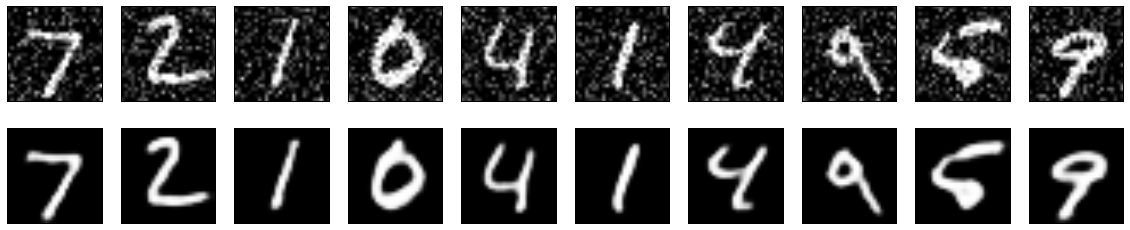

In [88]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_noisy_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()